# Multi Qubit Circuits

## importing libraries and installing pulser

In [1]:
pip install pulser

     |████████████████████████████████| 113 kB 4.1 MB/s 
     |████████████████████████████████| 15.7 MB 16.6 MB/s 
     |████████████████████████████████| 14.6 MB 4.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.simulation import Simulation
from pulser.waveforms import BlackmanWaveform,ConstantWaveform


## Register creation



In [3]:
def atoms_inline(size,spacing):
    reg_dict = {}
    for i in range(size):
        reg_dict["q"+str(i)] = np.array([0+i*spacing,0.])
    reg = Register(reg_dict)
    seq = Sequence(reg, Chadoq2)
    return reg,seq

## Gate Creation

In [4]:
########   NATIVE GATES #########

#Pauli X-gate
def X(target):
    target = "q"+str(target)
    
    pulse = Pulse.ConstantDetuning(BlackmanWaveform(raman_duration, np.pi), 0.,3*np.pi/2)
    
    if 'raman' not in seq.declared_channels:
        seq.declare_channel('raman','raman_local', target)
    else:
        seq.target(target,'raman')

    seq.add(pulse,'raman','wait-for-all')

#Pauli Y-gate
def Y(target):
  target = "q"+str(target)
  pulse = Pulse.ConstantDetuning(BlackmanWaveform(raman_duration, np.pi), 0.,np.pi)
  if 'raman' not in seq.declared_channels:
    seq.declare_channel('raman', 'raman_local', target)
  seq.target(target, 'raman')
  seq.add(pulse, 'raman')

#Pauli Z-gate
def Z(target):
  target = "q"+str(target)
  pulse = Pulse.ConstantDetuning(BlackmanWaveform(raman_duration, 2*np.pi), 0.,np.pi/2)
  if 'raman' not in seq.declared_channels:
    seq.declare_channel('raman','raman_local', target)
  seq.target(target,'raman')
  seq.add(pulse,'raman')

#Hadamard gate
def H(target):
    target = "q"+str(target)
   
    pulse = Pulse.ConstantDetuning(BlackmanWaveform(raman_duration, np.pi/2), 0.,np.pi/2, post_phase_shift=np.pi)
    
    if 'raman' not in seq.declared_channels:
        seq.declare_channel('raman','raman_local', target)
    else:
        seq.target(target,'raman')
  #add pulse de sequence
    seq.add(pulse, 'raman', 'wait-for-all')

#Control-Z gate
def CZ(control,target):
    target = "q"+str(target)
    control = "q"+str(control)

    #pulses
    pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(rydberg_duration, np.pi), 0., 0)
    twopi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(rydberg_duration, 2*np.pi), 0., 0)
    
    #Perform a single-qubit Identity gate in order to gate the right state basis in the simulation 
    if seq.declared_channels == {}:
      I(0)
    
    if 'ryd' not in seq.declared_channels:
        seq.declare_channel('ryd', 'rydberg_local', control)
    else:
        seq.target(control,'ryd')
   
    #add pulses to sequence
    seq.add(pi_pulse, 'ryd', 'wait-for-all')  # Wait for state preparation to finish.
    seq.target(target, 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target(control, 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')


########   COMBINATORY GATES #########

# Identity gate
def I(target):
    X(0)
    X(0)
    X(0)
    X(0)    

#Control-NOT gate
def CNOT(control,target):
    H(target)
    CZ(control,target)
    H(target)


## Creation of visuals

In [5]:
def get_Final_State(data):
  x = "{:.6f}"
  return [x.format(np.real(data[-1])),
          x.format(np.imag(data[-1])),
          x.format(np.abs(data[-1]**2))]

def Plot_States(qubits, smrate, simconf = None):

    simul = Simulation(seq, sampling_rate=smrate)

    if qubits > 0:
      res = simul.run()
      if qubits ==1:
          data1=[ket.overlap(qutip.ket('0')) for ket in res.states]
          data2=[ket.overlap(qutip.ket('1')) for ket in res.states]


          fig,axs = plt.subplots(2,figsize=(8,8))
          state1 = get_Final_State(data1)
         
          axs[0].plot(np.real(data1))
          axs[0].plot(np.imag(data1))
          axs[0].plot(np.abs(data1)**2)
          axs[0].legend([fr'real, final value: {state1[0]}',
                         fr'imaginary final value: {state1[1]}',
                         fr'probability final value: {state1[2]}'])
          axs[0].set(xlabel = r"Time [ns]", 
                     ylabel=fr'$ \langle\,0|\, \psi(t)\rangle$')
          

          state2 = get_Final_State(data2)

          axs[1].plot(np.real(data2))
          axs[1].plot(np.imag(data2))
          axs[1].plot(np.abs(data2)**2)
          axs[1].legend([fr'real, final value: {state2[0]}',
                         fr'imaginary, final value: {state2[1]}',
                         fr'probability, final value: {state2[2]}'])
          axs[1].set( xlabel = r"Time [ns]", 
                     ylabel=fr'$ \langle\,1 |\, \psi(t)\rangle$')

      else:
          fig,axs = plt.subplots(2**qubits,figsize=(15,10+2**qubits))
          for i in range(2**qubits):
            bra = format(i,"0"+str(qubits)+"b") #converts i to binary since each binary number represents one of the 2**qubit states that can be measured
            qutip_bra= "".join([str((int(x) + 1) % 10) for x in bra])#adds 1 to each digit in order to adapt to qutip's different conventions
            
            data=[ket.overlap(qutip.ket(qutip_bra,3)) for ket in res.states]
            state = get_Final_State(data)
            
            
            axs[i].plot(np.real(data))
            axs[i].plot(np.imag(data))
            axs[i].plot(np.abs(data)**2)
            axs[i].legend([fr'real, final value: {state[0]}',
                         fr'imaginary, final value: {state[1]}',
                         fr'probability, final value: {state[2]}'])
            axs[i].set(xlabel = r"Time [ns]", 
                       ylabel=fr'$ \langle\,{bra}|\, \psi(t)\rangle$')
    else:
       raise ValueError('Not a valid amount of qubits')

    return res
   

In [6]:
def most_freq_results(res):    # display bar graph of most frequent results

    count = res.sample_final_state()

    meas_res = res.measure()

    most_freq_results = {k:v for k,v in count.items()}

    plt.figure()
    
    plt.bar(list(most_freq_results.keys()), list(most_freq_results.values()), width=0.9)

    plt.xticks(rotation='vertical')
    plt.show()

    return meas_res

In [7]:
def plot_noisy_comp(qubits, smrate, simconfig):
    # set simconf and run sim for noisy results
    simul = Simulation(seq, smrate)
    config = SimConfig(simconf)
    simul.set_configuration(config)
    noisy_res = simul.run()
    # reset simconf and run sim for clean results
    simul.reset_config()
    clean_res = simul.run()

    # create plot with both datasets using plot_states function structure

    if qubits > 0:
      if qubits ==1:
          data1_c=[ket.overlap(qutip.ket('0')) for ket in clean_res.states]
          data2_c=[ket.overlap(qutip.ket('1')) for ket in clean_res.states]
          data1_n=[ket.overlap(qutip.ket('0')) for ket in noisy_res.states]
          data2_n=[ket.overlap(qutip.ket('1')) for ket in noisy_res.states]

          fig,axs = plt.subplots(2,figsize=(8,8))
          state1_c = get_Final_State(data1_c)
          state1_n = get_Final_State(data1_n)

          axs[0].plot(np.abs(data1_c)**2)
          axs[0].plot(np.abs(data1_n)**2)

          axs[0].legend()
          axs[0].set()
          

          state2_c = get_Final_State(data2_c)
          state2_n = get_Final_State(data2_n)

          axs[1].plot(np.abs(data2_c)**2)
          axs[1].plot(np.abs(data2_n)**2)

          axs[1].legend([fr'probability without noise, final value: {state2_c[2]}', fr'probability with noise, final value: {state2_n[2]}'])
          axs[1].set( xlabel = r"Time [ns]", 
                     ylabel=fr'$ \langle\,1 |\, \psi(t)\rangle$')

      else:
          fig,axs = plt.subplots(2**qubits,figsize=(15,10+2**qubits))
          for i in range(2**qubits):
            bra = format(i,"0"+str(qubits)+"b") #converts i to binary since each binary number represents one of the 2**qubit states 
            qutip_bra= "".join([str((int(x) + 1) % 10) for x in bra])#adds 1 to each digit in order to adapt to qutip's different conventions
            
            data_c=[ket.overlap(qutip.ket(qutip_bra,3)) for ket in clean_res.states]
            data_n=[ket.overlap(qutip.ket(qutip_bra,3)) for ket in noisy_res.states]

            state_c = get_Final_State(data_c)
            state_n = get_Final_State(data_n)            

            axs[i].plot(np.abs(data_c)**2)
            axs[i].plot(np.abs(data_n)**2)

            axs[i].legend([fr'real, final value: {state[0]}',
                         fr'imaginary, final value: {state[1]}',
                         fr'probability, final value: {state[2]}'])
            axs[i].set(xlabel = r"Time [ns]", 
                       ylabel=fr'$ \langle\,{bra}|\, \psi(t)\rangle$')
    else:
       raise ValueError('Not a valid amount of qubits')

In [8]:
supp_bases = Chadoq2.supported_bases
print(supp_bases)

{'digital', 'ground-rydberg'}


## Simulation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  


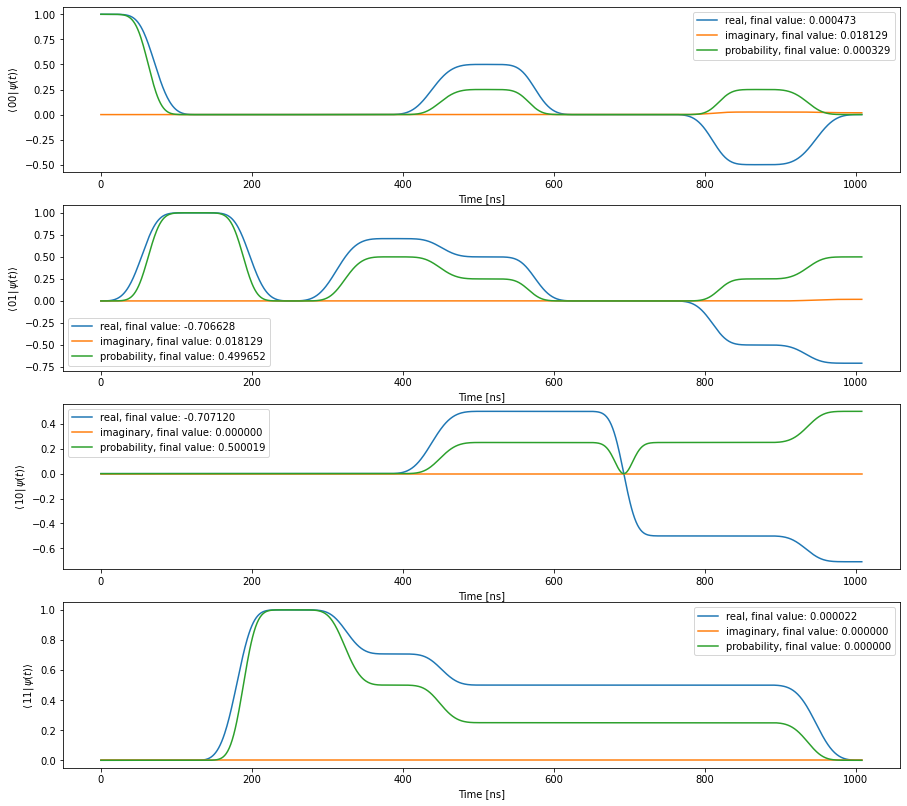

In [9]:
qubits = 2 # gets very slow above 4-5 qubits
spacing = 4

#duration of pulses for each channel
raman_duration = 250 
rydberg_duration = 250 

reg, seq = atoms_inline(qubits,spacing)


X(1)
X(0)
H(0)
CNOT(0,1)

#seq.draw(draw_phase_shifts=True)

res = Plot_States(qubits, 0.5)

# meas1 = most_freq_results(res)
# print(type(meas1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.


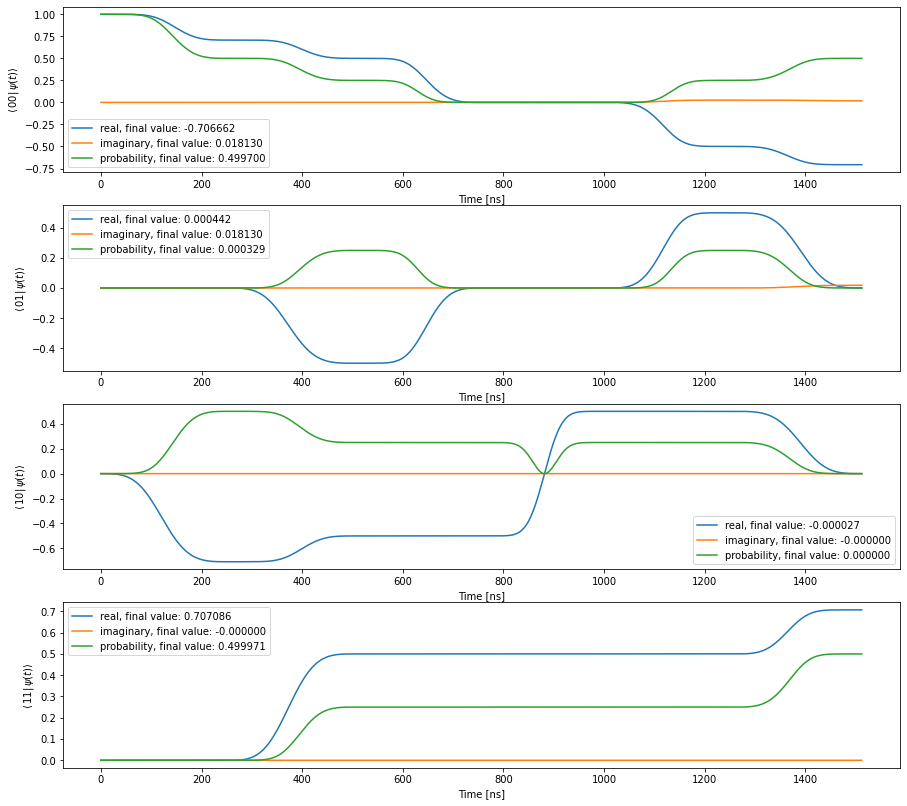

In [11]:
qubits = 2 # gets very slow above 4-5 qubits
spacing = 4
#duration of pulses for each channel
raman_duration = 250 
rydberg_duration = 250 

reg, seq = atoms_inline(qubits,spacing)

H(0)
CNOT(0,1)




res = Plot_States(qubits, 1)

#meas1 = most_freq_results(res)
#print(type(meas1))